# FSRS offline vs SuperMemo 15

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs-vs-sm15/blob/main/compare_offline.ipynb)

In [1]:
username = 'idea'
date = '2023-08-15' # YYYY-MM-DD

## 1. SuperMemo Data Filter

This section filters out the repetition history of Concept and Topic. It only keeps the repetition history of Item. It also remove the title of each item for privacy.

You can upload the `Repetition History.txt` file exported from SuperMemo to the following cell. The output will be saved to the same folder as the input file. You can share the output file with others without worrying about privacy. The output file is named `Repetition History-{username}-{date}.txt`.

In [2]:
def correctly_process_file(file_path, output_file_path):
    result_lines = []  # To store the processed lines
    is_item_section = False  # Flag to identify whether we are in an item section

    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            # Check if the line starts a new item section
            if line.startswith('Item #'):
                is_item_section = True
                item_number = line.split(":")[0]  # Keep only the "Item #" part
                result_lines.append(item_number)
            elif line.startswith('Topic #') or line.startswith('Concept #'):
                is_item_section = False
            # If in item section, only keep the repetition records
            elif is_item_section and line.startswith('ElNo'):
                result_lines.append(line)
            elif line.startswith('Repetition') or line.startswith('Date'):
                result_lines.append(line)
            elif is_item_section and line == "":
                result_lines.append(line)

    # Saving the processed content to the output file
    with open(output_file_path, 'w', encoding='utf-8') as file:
        for line in result_lines:
            file.write(line + '\n')


input_file_path = './Repetition History.txt'
output_file_path = f'./Repetition History-{username}-{date}.txt'
# correctly_process_file(input_file_path, output_file_path)

## 2. SuperMemo Data Converter

This section converts the SM-15 repetition history to the same format as FSRS.

In [3]:
import pandas as pd
import csv

# Function to extract keys and values from a line
def extract_keys_values(line):
    parts = line.strip().split(" ")
    keys, values = [], []
    for part in parts:
        key, value = part.split("=")
        keys.append(key)
        values.append(value)
    return keys, values

filename = f'Repetition History-{username}-{date}'

# Path to the input TXT file
txt_file_path = f'{filename}.txt'

# Extract all unique keys from the data to form the headers
unique_keys = set()
with open(txt_file_path, 'r', encoding='utf-8') as txt_file:
    for line in txt_file:
        if line.startswith("ElNo"):
            keys, _ = extract_keys_values(line)
            unique_keys.update(keys)

# Sort the keys to maintain a consistent order
headers = sorted(list(unique_keys))

# Path to the output CSV file
csv_file_path = f'{filename}.csv'

# Write the data to CSV with the identified headers and considering missing values
with open(txt_file_path, 'r', encoding='utf-8') as txt_file, open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)  # Write the headers

    for line in txt_file:
        if line.startswith("ElNo"):
            keys, values = extract_keys_values(line)

            # Consider missing values by aligning with headers
            row = [None] * len(headers)
            for key, value in zip(keys, values):
                index = headers.index(key)
                row[index] = value

            writer.writerow(row)

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Convert the "Date" column to standard date format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True).dt.strftime('%Y-%m-%d')

# Sort the DataFrame by "ElNo" and "Date" (ascending for both)
df = df.sort_values(by=['ElNo', 'Date'], ascending=[True, True])

print(f"Number of repetitions: {df.shape[0]}")
print(f"Number of items: {df['ElNo'].unique().shape[0]}")

# Remove unnecessary columns
df.drop(["Difficulty", "Hour", "Postpones", "Priority"], axis=1, inplace=True, errors="ignore")

# Remove items that first row was not the first repetition
df = df.groupby('ElNo').filter(lambda group: (group['Rep'].iloc[0] == 1) and (group['Laps'].iloc[0] == 0))
print(f"Number of repetitions: {df.shape[0]}")

# Remove the first repetition of each item
df.drop(df[(df['Rep'] == 1) & (df['Laps'] == 0)].index, inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

# Remove items that have been reset
df = df.groupby('ElNo').filter(lambda group: (group['Grade'] > 5).sum() == 0)
print(f"Number of repetitions: {df.shape[0]}")

# Remove items that have invalid "expFI" values
df = df.groupby('ElNo').filter(lambda group: (group['expFI'] == 100).sum() == 0)
print(f"Number of repetitions: {df.shape[0]}")

# Keep the first repetitions of the same item on the same day
df.drop_duplicates(subset=['Date', 'ElNo'], keep='first', inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

# Rank the repetitions of each item
df['i'] = df.groupby('ElNo').cumcount() + 1

# Calculate the time difference between repetitions
df['Date'] = pd.to_datetime(df['Date'])
df['delta_t'] = df['Date'].diff().dt.days
df['delta_t'] = df['delta_t'].fillna(0)
df.loc[df['i'] == 1, 'delta_t'] = 0
df['delta_t'] = df['delta_t'].astype(int)

# Rename columns to match FSRS dataset format
df.rename(columns={'ElNo': 'card_id', 'Date': 'review_date'}, inplace=True)

# Convert "Grade" to "review_rating"
# 0, 1, 2 -> 1, 3 -> 2, 4 -> 3, 5 -> 4
df['review_rating'] = df['Grade'].map({0: 1, 1: 1, 2: 1, 3: 2, 4: 3, 5: 4})
df['review_time'] = 0


# Create "t_history" and "r_history" features for training FSRS
from itertools import accumulate

def cum_concat(x):
    return list(accumulate(x))

t_history = df.groupby('card_id', group_keys=False)['delta_t'].apply(lambda x: cum_concat([[int(i)] for i in x]))
df['t_history']=[','.join(map(str, item[:-1])) for sublist in t_history for item in sublist]
r_history = df.groupby('card_id', group_keys=False)['review_rating'].apply(lambda x: cum_concat([[i] for i in x]))
df['r_history']=[','.join(map(str, item[:-1])) for sublist in r_history for item in sublist]

# Create "y" label for training FSRS
df['y'] = df['review_rating'].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])

df.dropna(inplace=True)
print(f"Number of repetitions: {df.shape[0]}")

def remove_non_continuous_rows(group):
    discontinuity = group['i'].diff().fillna(1).ne(1)
    if not discontinuity.any():
        return group
    else:
        first_non_continuous_index = discontinuity.idxmax()
        return group.loc[:first_non_continuous_index-1]

df = df.groupby('card_id', as_index=False, group_keys=False).apply(remove_non_continuous_rows)
print(f"Number of repetitions: {df.shape[0]}")

# Save the final dataset
df.to_csv('revlog_history.tsv', sep="\t", index=False)

Number of repetitions: 50192
Number of items: 10508
Number of repetitions: 50084
Number of repetitions: 39298
Number of repetitions: 36293
Number of repetitions: 36293
Number of repetitions: 36290
Number of repetitions: 36290
Number of repetitions: 36290


## 3. Train & Compare

In [4]:
%pip install -q FSRS-Optimizer==4.12.0
import fsrs_optimizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fsrs_optimizer import plot_brier
from sklearn.metrics import mean_squared_error

revlogs = pd.read_csv('revlog_history.tsv', sep='\t', keep_default_na=False)
revlogs = revlogs[(revlogs['i'] > 1) & (revlogs['delta_t'] > 0) & (revlogs['t_history'].str.count(',0') == 0)]

optimizer = fsrs_optimizer.Optimizer()

S0_dataset = revlogs[revlogs['i'] == 2]
optimizer.S0_dataset_group = S0_dataset.groupby(by=['r_history', 'delta_t'], group_keys=False).agg({'y': ['mean', 'count']}).reset_index()

optimizer.define_model()
optimizer.pretrain(verbose=False)
optimizer.train(verbose=False)
print(optimizer.w)

Note: you may need to restart the kernel to use updated packages.
Pretrain finished!


  0%|          | 0/26147 [00:00<?, ?it/s]

Tensorized!
TRAIN: 18809 TEST: 7338
dataset built


train:   0%|          | 0/66920 [00:00<?, ?it/s]

TRAIN: 20455 TEST: 5692
dataset built


train:   0%|          | 0/66905 [00:00<?, ?it/s]

TRAIN: 20758 TEST: 5389
dataset built


train:   0%|          | 0/66880 [00:00<?, ?it/s]

TRAIN: 21771 TEST: 4376
dataset built


train:   0%|          | 0/66855 [00:00<?, ?it/s]

TRAIN: 22795 TEST: 3352
dataset built


train:   0%|          | 0/66840 [00:00<?, ?it/s]


Training finished!
[1.1478, 48.6912, 59.2586, 76.6071, 4.772, 0.7861, 0.5022, 0.2969, 1.568, 0.3718, 1.0117, 2.5967, 0.01, 0.3435, 1.7892, 0.7454, 2.1352]


Loss of FSRS offline: 0.3359
R-squared: -0.9550
RMSE: 0.0621
MAE: 0.0359
[0.54420503 0.39155196]


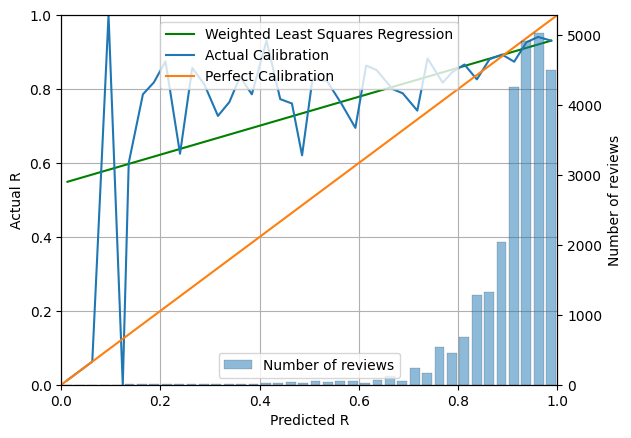

In [5]:
loss_before, loss_after = optimizer.evaluate()
print(f"Loss of FSRS offline: {loss_after:.4f}")
fig0 = plt.figure()
fsrs_metrics = plot_brier(optimizer.dataset['p'], optimizer.dataset['y'], bins=40, ax=fig0.add_subplot(111))
fsrs_metrics['log_loss'] = loss_after
fig0.show()

Loss of SM-15: 0.3789
R-squared: -21.4473
RMSE: 0.1373
MAE: 0.0688
[0.77115733 0.15073311]
Universal Metric of FSRS: 0.0457
Universal Metric of SM15: 0.0851


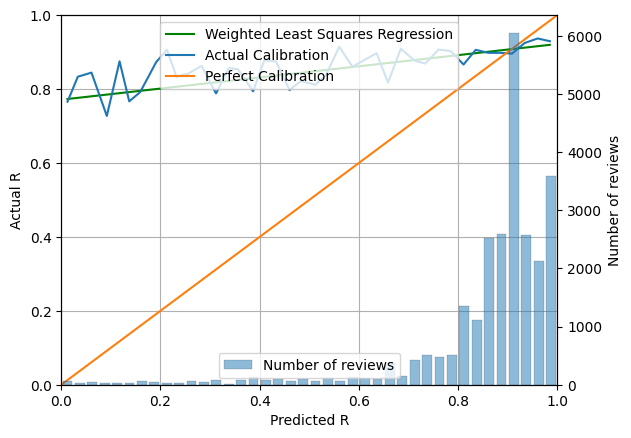

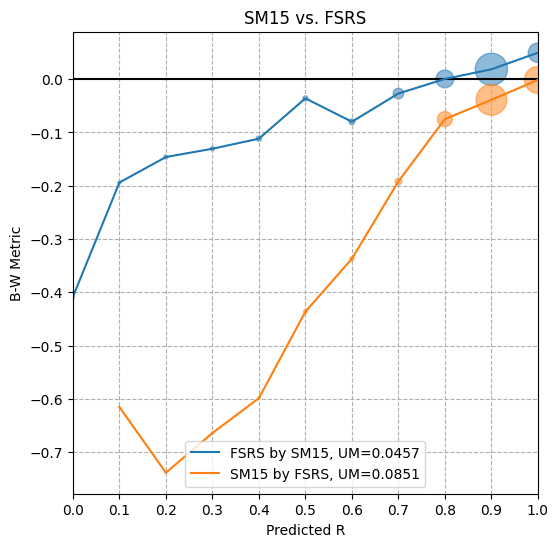

In [6]:
revlogs['p'] = optimizer.dataset['p']
revlogs['sm15_p'] = 1 - revlogs['expFI'] / 100
revlogs['log_loss'] = revlogs.apply(lambda row: - np.log(row['sm15_p']) if row['y'] == 1 else - np.log(1 - row['sm15_p']), axis=1)
log_loss = revlogs['log_loss'].mean()
print(f"Loss of SM-15: {log_loss:.4f}")
cross_comparison = revlogs[['sm15_p', 'p', 'y']].copy()
fig1 = plt.figure()
sm15_metrics = plot_brier(cross_comparison['sm15_p'], cross_comparison['y'], bins=40, ax=fig1.add_subplot(111))
fig1.show()
sm15_metrics['log_loss'] = log_loss

fig2 = plt.figure(figsize=(6, 6))
ax = fig2.gca()

cross_comparison['SM15_B-W'] = cross_comparison['sm15_p'] - cross_comparison['y']
cross_comparison['SM15_Bin'] = cross_comparison['sm15_p'].map(lambda x: round(x, 1))
cross_comparison['FSRS_B-W'] = cross_comparison['p'] - cross_comparison['y']
cross_comparison['FSRS_bin'] = cross_comparison['p'].map(lambda x: round(x, 1))

ax.axhline(y = 0.0, color = 'black', linestyle = '-')

cross_comparison_group = cross_comparison.groupby(by='SM15_Bin').agg({'y': ['mean'], 'FSRS_B-W': ['mean'], 'p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['p', 'mean'], sample_weight=cross_comparison_group['p', 'count'], squared=False)
fsrs_metrics['universal_metric_by_sm15'] = universal_metric
print(f"Universal Metric of FSRS: {universal_metric:.4f}")
cross_comparison_group['p', 'percent'] = cross_comparison_group['p', 'count'] / cross_comparison_group['p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['FSRS_B-W', 'mean'], s=cross_comparison_group['p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['FSRS_B-W', 'mean'], label=f'FSRS by SM15, UM={universal_metric:.4f}')

cross_comparison_group = cross_comparison.groupby(by='FSRS_bin').agg({'y': ['mean'], 'SM15_B-W': ['mean'], 'sm15_p': ['mean', 'count']})
universal_metric = mean_squared_error(cross_comparison_group['y', 'mean'], cross_comparison_group['sm15_p', 'mean'], sample_weight=cross_comparison_group['sm15_p', 'count'], squared=False)
sm15_metrics['universal_metric_by_fsrs_offline'] = universal_metric
print(f"Universal Metric of SM15: {universal_metric:.4f}")
cross_comparison_group['sm15_p', 'percent'] = cross_comparison_group['sm15_p', 'count'] / cross_comparison_group['sm15_p', 'count'].sum()
ax.scatter(cross_comparison_group.index, cross_comparison_group['SM15_B-W', 'mean'], s=cross_comparison_group['sm15_p', 'percent'] * 1024, alpha=0.5)
ax.plot(cross_comparison_group['SM15_B-W', 'mean'], label=f'SM15 by FSRS, UM={universal_metric:.4f}')

ax.legend(loc='lower center')
ax.grid(linestyle='--')
ax.set_title("SM15 vs. FSRS")
ax.set_xlabel('Predicted R')
ax.set_ylabel('B-W Metric')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.1, 0.1))

fig2.show()

In [7]:
{
    'user': username,
    'date': date,
    'size': len(revlogs),
    'fsrs_offline': fsrs_metrics,
    'sm15': sm15_metrics
}

{'user': 'idea',
 'date': '2023-08-15',
 'size': 26147,
 'fsrs_offline': {'R-squared': -0.9549855740421871,
  'RMSE': 0.06207436098689445,
  'MAE': 0.03589812064760886,
  'log_loss': 0.33585077218659887,
  'universal_metric_by_sm15': 0.04573969675610996},
 'sm15': {'R-squared': -21.447341767679422,
  'RMSE': 0.1373072894342879,
  'MAE': 0.0687765326806057,
  'log_loss': 0.37886050539237454,
  'universal_metric_by_fsrs_offline': 0.08507010546825809}}